In [1]:
from glob import glob
import os
import IPython.display as display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_io as tfio
import cv2
import re

In [2]:
# important for reproducibility
seed = 42

# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE

base_dir = os.path.abspath('..')
train_dir = os.path.join(base_dir,"data","train")
val_dir = os.path.join(base_dir,"data","test")

# Image size that we are going to use
IMG_SIZE = (128,128)
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Number of classes + 1 for background
N_CLASSES = 4

In [3]:

def parse_image(img_path: str) -> dict:
    
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.

    Returns
    -------
    dict
        Dictionary mapping an image and its ground truth
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    image = tf.image.resize(image, IMG_SIZE,method='nearest')
    


    mask_path = tf.strings.regex_replace(img_path, "original_retinal_images", "masks_new")
    mask_path = tf.strings.regex_replace(mask_path, "jpg", "png")
       
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=0)
    mask = tf.image.resize(mask, IMG_SIZE,method='nearest')

    return {'image': image, 'segmentation_mask': mask}



train_dataset = tf.data.Dataset.list_files(os.path.join(train_dir , 'original_retinal_images' , "*.jpg"),shuffle=False)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(os.path.join(val_dir , 'original_retinal_images' , "*.jpg"),shuffle=False)
val_dataset = val_dataset.map(parse_image)

In [4]:
train_images = np.array([img['image'] for img in train_dataset.as_numpy_iterator()])
train_masks = np.array([(np.eye(N_CLASSES)[img['segmentation_mask']]) for img in train_dataset.as_numpy_iterator()])
train_masks = np.squeeze(train_masks,axis=3)

val_images = np.array([img['image'] for img in val_dataset.as_numpy_iterator()])
val_masks = np.array([(np.eye(N_CLASSES)[img['segmentation_mask']]) for img in val_dataset.as_numpy_iterator()])
val_masks = np.squeeze(val_masks,axis=3)


In [5]:
train_masks.shape

(54, 128, 128, 4)

In [6]:
train_images.shape

(54, 128, 128, 3)

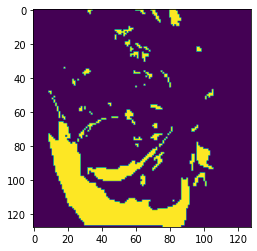

In [7]:
plt.imshow(train_masks[16][:,:,1])

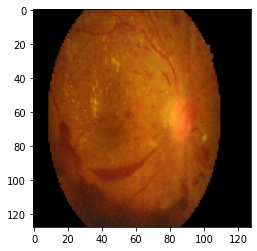

In [8]:
plt.imshow(train_images[16])

In [ ]:
#batch_size = 64

In [39]:

# Train data generator
x_gen_args = dict(
                        rescale=1./255,
                        #featurewise_center=True,
                        #featurewise_std_normalization=True,
                        #shear_range=0.2,
                        #zoom_range=0.1,
                        #channel_shift_range=?,
                        #width_shift_range=0.5,
                        #height_shift_range=0.5,
                        #brightness_range=[0.8,1.2],
                        rotation_range = 20,
                        horizontal_flip=True,
                        fill_mode='nearest'
                    )


y_gen_args = dict(     
                        #featurewise_center=True,
                        #featurewise_std_normalization=True,
                        #shear_range=0.2,
                        #zoom_range=0.1,
                        #channel_shift_range=?,
                        #width_shift_range=0.5,
                        #height_shift_range=0.5,
                        #brightness_range=[0.8,1.2],
                        rotation_range = 20,
                        horizontal_flip=True,
                        fill_mode='nearest'
                    )


image_datagen = ImageDataGenerator(**x_gen_args)
mask_datagen = ImageDataGenerator(**y_gen_args)

image_datagen.fit(train_images, augment=True, seed=seed)
mask_datagen.fit(train_masks, augment=True, seed=seed)






In [40]:
image_generator = image_datagen.flow(
    train_images,
    #batch_size=batch_size,
    shuffle = True, # shuffle the training data
    seed=seed)

mask_generator = mask_datagen.flow(
    train_masks,
    #batch_size=batch_size,
    shuffle = True,
    seed=seed)

train_generator = zip(image_generator, mask_generator)

In [41]:
val_image_datagen = ImageDataGenerator(**x_gen_args)
val_mask_datagen = ImageDataGenerator(**y_gen_args)

val_image_datagen.fit(val_images, augment=False, seed=seed)
val_mask_datagen.fit(val_masks, augment=False, seed=seed)

val_image_generator = val_image_datagen.flow(
    val_images,
    #batch_size=batch_size,
    shuffle = True, # shuffle the training data
    seed=seed)

val_mask_generator = val_mask_datagen.flow(
    val_masks,
    #batch_size=batch_size,
    shuffle = True,
    seed=seed)

val_generator = zip(val_image_generator, val_mask_generator)

In [ ]:
# import wandb
# from wandb.keras import WandbCallback

# wandb.login()
# wandb.init(project="Unet-revisited")

In [11]:
# class MyMeanIOU(tf.keras.metrics.MeanIoU):
#     def update_state(self, y_true, y_pred, sample_weight=None):
#         return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1))

In [69]:
# -- Keras Functional API -- #
# -- UNet Implementation -- #
# Everything here is from tensorflow.keras.layers
# I imported tensorflow.keras.layers * to make it easier to read
d_rate = 0.2
input_size = (*(IMG_SIZE), N_CHANNELS)

# If you want to know more about why we are using `he_normal`:
# https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize/319849#319849  
# Or the excellent fastai course:
# https://github.com/fastai/course-v3/blob/master/nbs/dl2/02b_initializing.ipynb
initializer = 'he_normal'


# -- Encoder -- #
# Block encoder 1
inputs = Input(shape=input_size)
conv_enc_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=initializer)(inputs)
conv_enc_1 = Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer=initializer)(conv_enc_1)
#conv_enc_1 = Dropout(d_rate)(conv_enc_1)
# Block encoder 2
max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
conv_enc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_2)

# Block  encoder 3
max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
conv_enc_3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_3)
#conv_enc_3 = Dropout(d_rate)(conv_enc_3)
# Block  encoder 4
max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
conv_enc_4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_enc_4)

# -- Encoder -- #

# ----------- #
maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(maxpool)
conv = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv)
# ----------- #

# -- Decoder -- #
# Block decoder 1
up_dec_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_1)
conv_dec_1 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_1)


# Block decoder 2
up_dec_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_2)
conv_dec_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_2)

# Block decoder 3
up_dec_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_3)
conv_dec_3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_3)
#conv_dec_3 = Dropout(d_rate)(conv_dec_3)
# Block decoder 4
up_dec_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(merge_dec_4)
conv_dec_4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
conv_dec_4 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = initializer)(conv_dec_4)
#conv_dec_4 = Dropout(d_rate)(conv_dec_4)
# -- Dencoder -- #

output = Conv2D(N_CLASSES, 1, activation = 'softmax')(conv_dec_4)
model = tf.keras.Model(inputs = inputs, outputs = output)
model.compile(optimizer=Adam(learning_rate=0.0006), loss = 'categorical_crossentropy')#metrics=[tf.keras.metrics.MeanIoU(num_classes=4)] )

In [70]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 128, 128, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_96[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_16 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_97[0][0]                  
____________________________________________________________________________________________

In [71]:
epochs = 120
#weights = {0:1.0, 1:8.0, 2:10.0, 3:10.0}

In [72]:
# fit the generator
history = model.fit(
                    train_generator,
                    #batch_size = 256, #num_train/batch_size, 
                    steps_per_epoch = 16,
                    validation_data=val_generator,
                    validation_steps = 1,#num_val/batch_size,
                    epochs=epochs,
                    verbose=1,
                    #callbacks = [WandbCallback()]
                    )

Epoch 1/120
16/16 [==============================] - 6s 315ms/step - loss: 0.5057 - val_loss: 0.1423
Epoch 2/120
16/16 [==============================] - 5s 300ms/step - loss: 0.1109 - val_loss: 0.1594
Epoch 3/120
16/16 [==============================] - 5s 300ms/step - loss: 0.1071 - val_loss: 0.1481
Epoch 4/120
16/16 [==============================] - 5s 300ms/step - loss: 0.1029 - val_loss: 0.1509
Epoch 5/120
16/16 [==============================] - 5s 300ms/step - loss: 0.1031 - val_loss: 0.1460
Epoch 6/120
16/16 [==============================] - 5s 300ms/step - loss: 0.1017 - val_loss: 0.1391
Epoch 7/120
16/16 [==============================] - 5s 302ms/step - loss: 0.0984 - val_loss: 0.1402
Epoch 8/120
16/16 [==============================] - 5s 302ms/step - loss: 0.1131 - val_loss: 0.1671
Epoch 9/120
16/16 [==============================] - 5s 301ms/step - loss: 0.1025 - val_loss: 0.1541
Epoch 10/120
16/16 [==============================] - 5s 301ms/step - loss: 0.1027 - val_lo

16/16 [==============================] - 5s 309ms/step - loss: 0.0491 - val_loss: 0.2486
Epoch 82/120
16/16 [==============================] - 5s 307ms/step - loss: 0.0486 - val_loss: 0.2196
Epoch 83/120
16/16 [==============================] - 5s 304ms/step - loss: 0.0488 - val_loss: 0.2338
Epoch 84/120
16/16 [==============================] - 5s 308ms/step - loss: 0.0484 - val_loss: 0.2263
Epoch 85/120
16/16 [==============================] - 5s 305ms/step - loss: 0.0489 - val_loss: 0.1816
Epoch 86/120
16/16 [==============================] - 5s 304ms/step - loss: 0.0489 - val_loss: 0.2254
Epoch 87/120
16/16 [==============================] - 5s 304ms/step - loss: 0.0482 - val_loss: 0.2466
Epoch 88/120
16/16 [==============================] - 5s 307ms/step - loss: 0.0484 - val_loss: 0.2196
Epoch 89/120
16/16 [==============================] - 5s 303ms/step - loss: 0.0481 - val_loss: 0.2627
Epoch 90/120
16/16 [==============================] - 5s 308ms/step - loss: 0.0475 - val_loss: 

In [73]:
history.history.keys()


dict_keys(['loss', 'val_loss'])

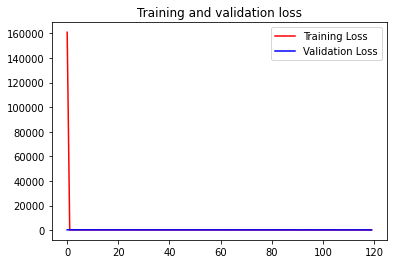

In [74]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline

# acc =  history.history['my_mean_iou']
# val_acc = history.history['val_my_mean_iou']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training IOU')
# plt.plot(epochs, val_acc, 'b', label='Validation IOU')
# plt.title('Training and validation IOU')
# plt.legend()
# plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [75]:
example = train_images[16]

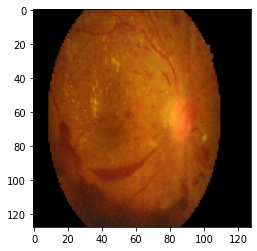

In [76]:
plt.imshow(example)

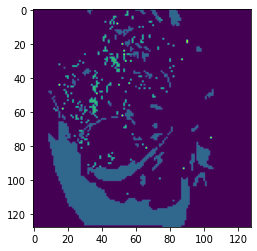

In [53]:
plt.imshow(np.argmax(train_masks[16],axis=-1))

In [54]:
np.unique(np.argmax(train_masks[16],axis=-1),return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([13659,  2432,   275,    18], dtype=int64))

In [77]:
example = tf.expand_dims(example,axis=0)

In [78]:
prediction = model.predict(example)

In [79]:
prediction.shape

(1, 128, 128, 4)

In [80]:
prediction = tf.squeeze(prediction,axis=0)

In [81]:
res = tf.argmax(prediction, axis=-1)

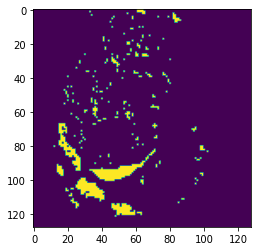

In [82]:
plt.imshow(res)

In [83]:
np.unique(res,return_counts=True)

(array([0, 1], dtype=int64), array([15572,   812], dtype=int64))

In [24]:
prediction = prediction.numpy()

In [ ]:
prediction = tf.argmax(prediction, axis=-1)

In [ ]:
prediction = tf.squeeze(prediction,axis=0)

In [ ]:
res = prediction.numpy()

In [ ]:
np.unique(res)